In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [2]:
features = np.genfromtxt("./Aggregated_Data.csv", delimiter=",", usecols=(1, 3, 4, 5))
targets = np.genfromtxt("./Aggregated_Data.csv", delimiter=",", usecols=8)

trainingFeatures, testingFeatures, trainingTargets, testingTargets = train_test_split(features, targets, test_size = 0.25, random_state=0)


In [3]:
#followed the lecture slides on how to solve for mean squared error
def meanSquaredError(prediction, answer):
    sum = 0
    for i in range(0, prediction.shape[0]):
        sum = sum + (answer[i]-prediction[i])**2
    return sum/prediction.shape[0]

In [4]:
#follows homework 2 discussion on finding training and testing errors
def findMSEForModel(depth, trainingFeatures, trainingTargets, testingFeatures, testingTargets):
    classifier = DecisionTreeClassifier(criterion="entropy", max_depth=depth).fit(trainingFeatures, trainingTargets)
    testingPredictions = classifier.predict(testingFeatures)
    trainingPredictions = classifier.predict(trainingFeatures)
    trainingMSE = meanSquaredError(trainingPredictions, trainingTargets)
    testingMSE = meanSquaredError(testingPredictions, testingTargets)
    return [trainingMSE, testingMSE]

In [5]:
#follows the homework 2 discussion in creating the folds for cross-validation
def crossValidation(depth, folds, trainingFeatures, trainingTargets):
    kfold = KFold(n_splits=folds, shuffle=False)
    errors = []
    for train, test in kfold.split(trainingFeatures, trainingTargets):
        Xtrain, Xtest = trainingFeatures[train], trainingFeatures[test]
        Ytrain, Ytest = trainingTargets[train], trainingTargets[test]
        classifier = DecisionTreeClassifier(criterion = "entropy", max_depth = depth).fit(Xtrain, Ytrain)
        predictions = classifier.predict(Xtest)
        errors.append(meanSquaredError(predictions, Ytest))
    return np.mean(errors)

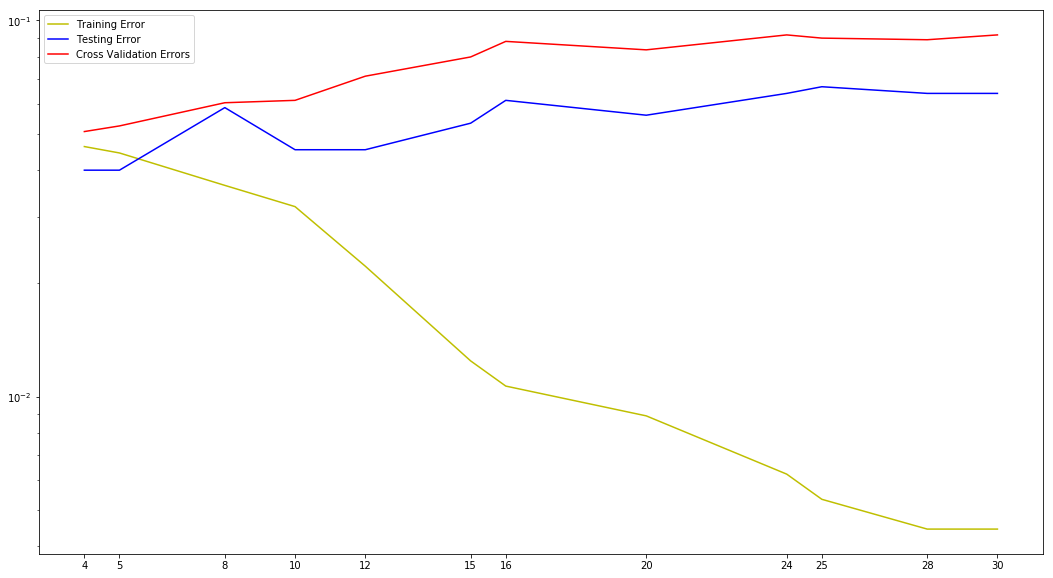

In [6]:
depths = [4, 5, 8, 10, 12, 15, 16, 20, 24, 25, 28, 30]
crossValidationErrors = []
trainingMSE = []
testingMSE = []
#follows the homework 2 discussion for finding and plotting the errors
for depth in depths:
    crossValidationErrors.append(crossValidation(depth, 5, trainingFeatures, trainingTargets))
    modelMSE = findMSEForModel(depth, trainingFeatures, trainingTargets, testingFeatures, testingTargets)
    trainingMSE.append(modelMSE[0])
    testingMSE.append(modelMSE[1])
plt.rcParams["figure.figsize"] = (18.0, 10.0)
plt.semilogy(depths, trainingMSE, color='y', label = "Training Error")
plt.semilogy(depths, testingMSE, color='b', label = "Testing Error")
plt.semilogy(depths, crossValidationErrors, color = "r", label = "Cross Validation Errors")
plt.xticks(depths)
plt.legend()
plt.show()

In [7]:
#follows the Decision Tree Classifier documentation on Scikit Learn to create and train the classifier
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
bestDepth = depths[crossValidationErrors.index(min(crossValidationErrors))]
classifier = DecisionTreeClassifier(criterion = "entropy", max_depth = bestDepth)
classifier.fit(trainingFeatures, trainingTargets)
predictions = classifier.predict(testingFeatures)
accuracy = classifier.score(testingFeatures, testingTargets)
print("The accuracy of the classifier is: " + str(accuracy))

#follows the Decision Tree information page for exporting the tree graph
#https://scikit-learn.org/stable/modules/tree.html
#used http://www.webgraphviz.com/ to convert the .dot file to a .png file
export_graphviz(classifier, out_file='Decision_Tree')


The accuracy of the classifier is: 0.96


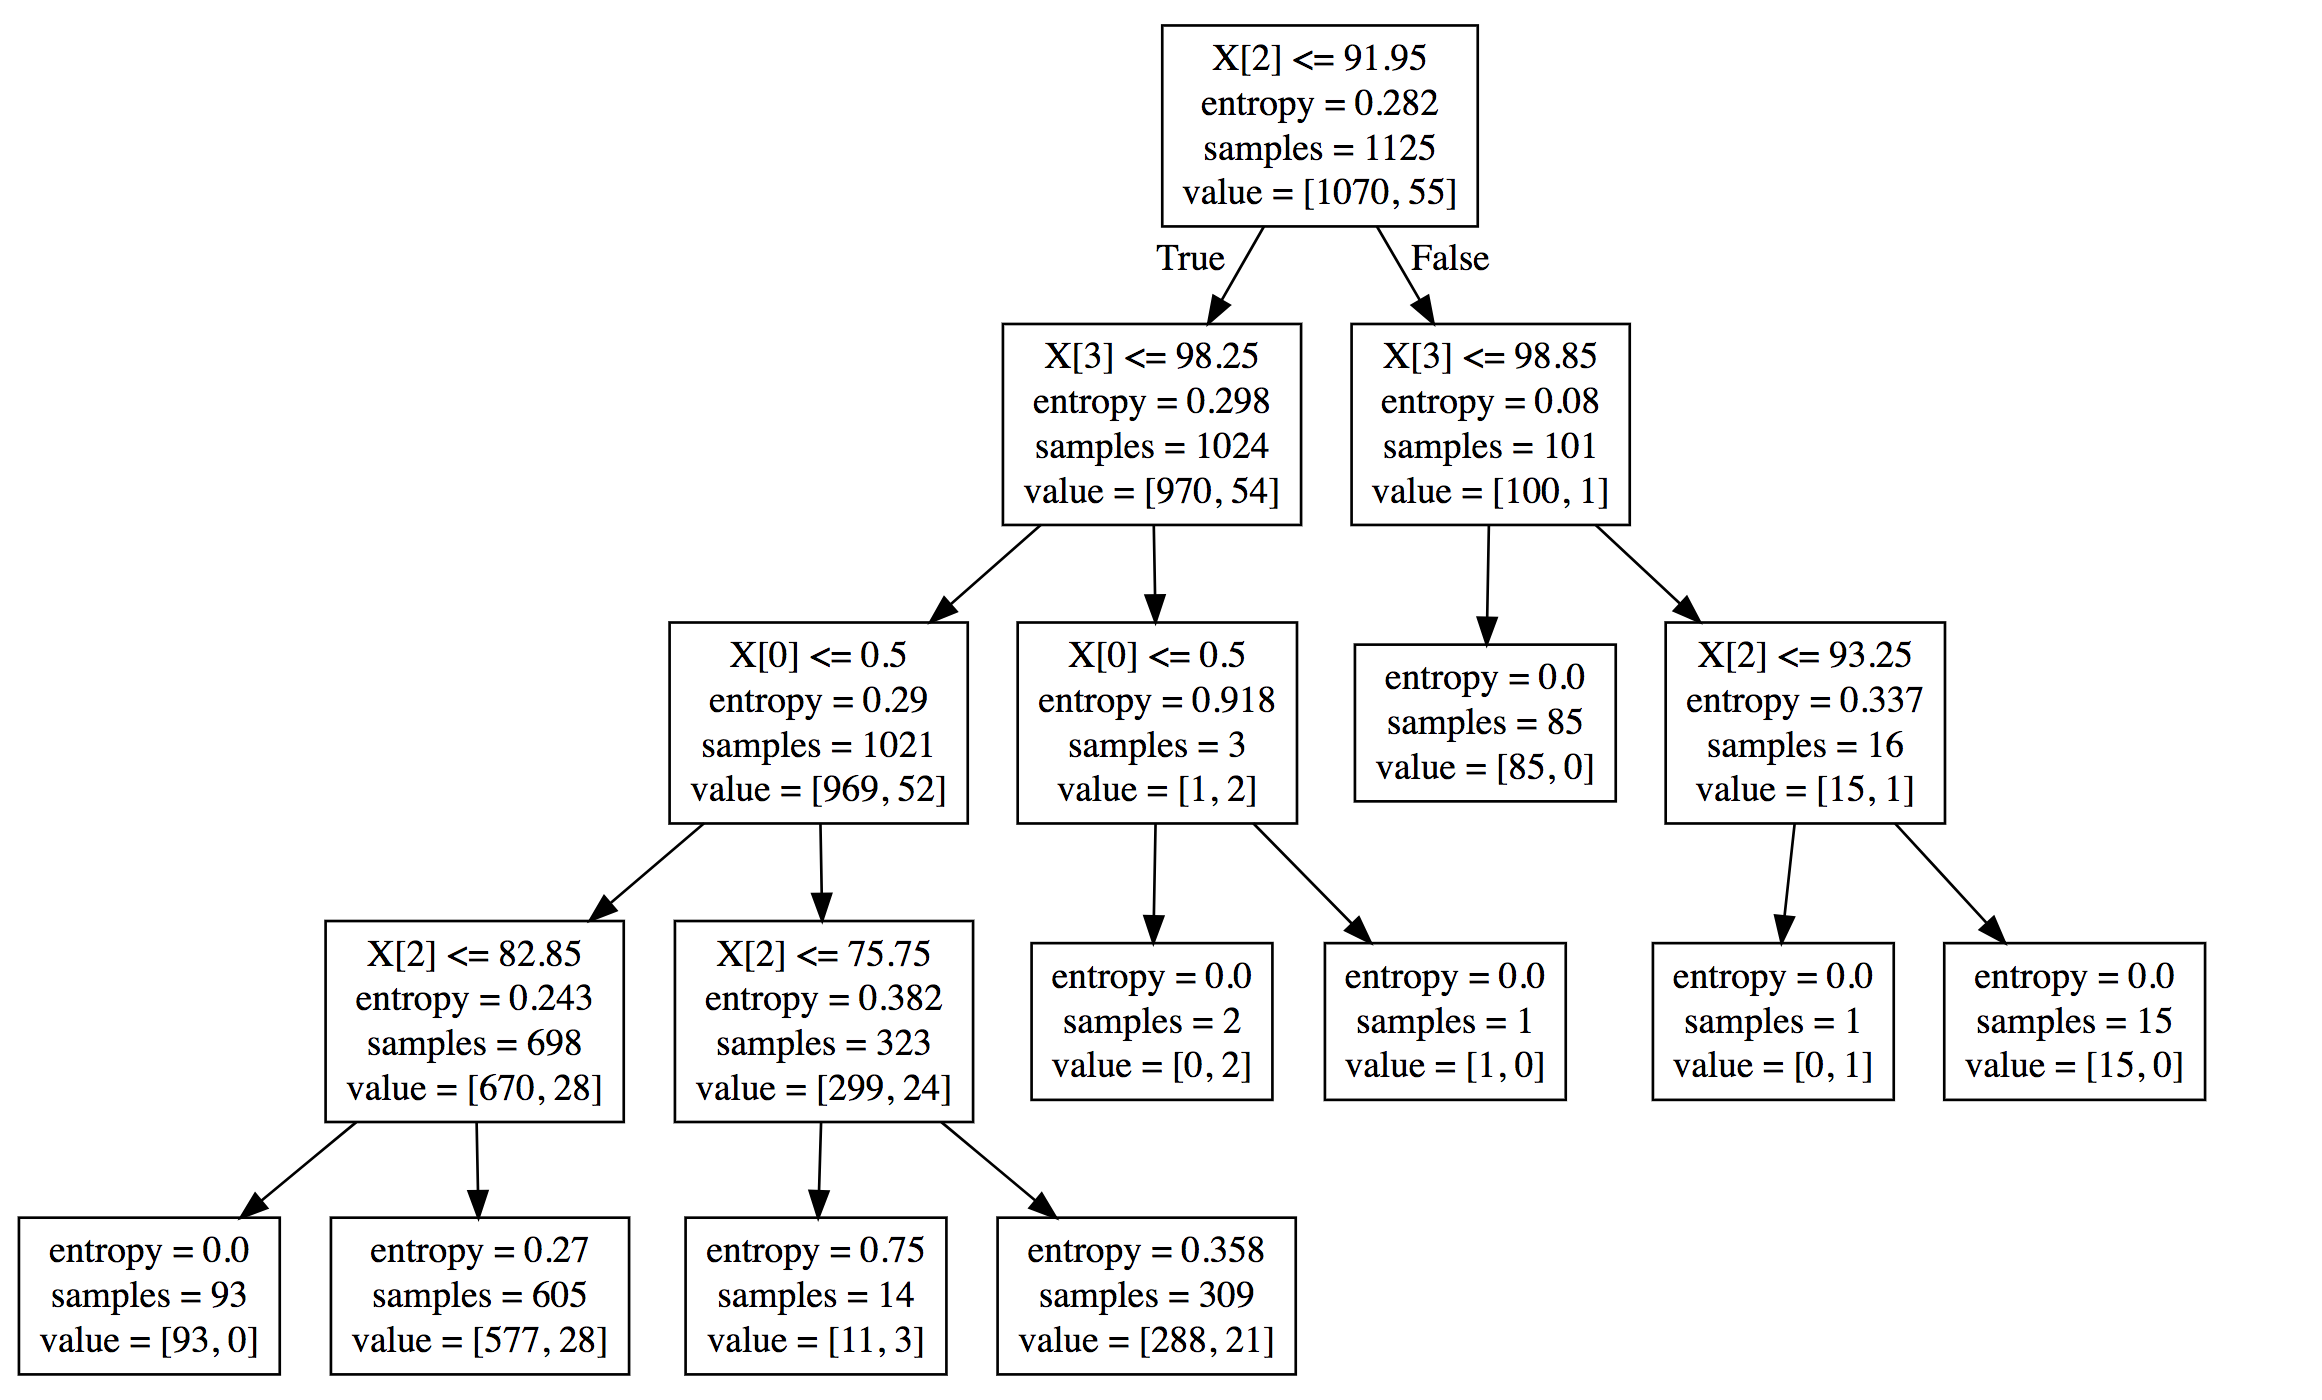

In [8]:
def ROCValues(threshold, probabilities, testingTargets):
    truePositives = 0
    trueNegatives = 0
    falsePositives = 0
    falseNegatives = 0
    for i in range(0, probabilities.shape[0]):
        if (probabilities[i][1] <= threshold):
            if(testingTargets[i] == 0):
                trueNegatives +=1
            else:
                falseNegatives += 1
        else:
            if(testingTargets[i] == 1):
                truePositives += 1
            else:
                falsePositives +=1
    truePositiveRate = truePositives/(truePositives+falseNegatives)
    falsePositiveRate = falsePositives/(trueNegatives+falsePositives)
    return [falsePositiveRate, truePositiveRate]

The area under the ROC curve is: 0.6286559888579387


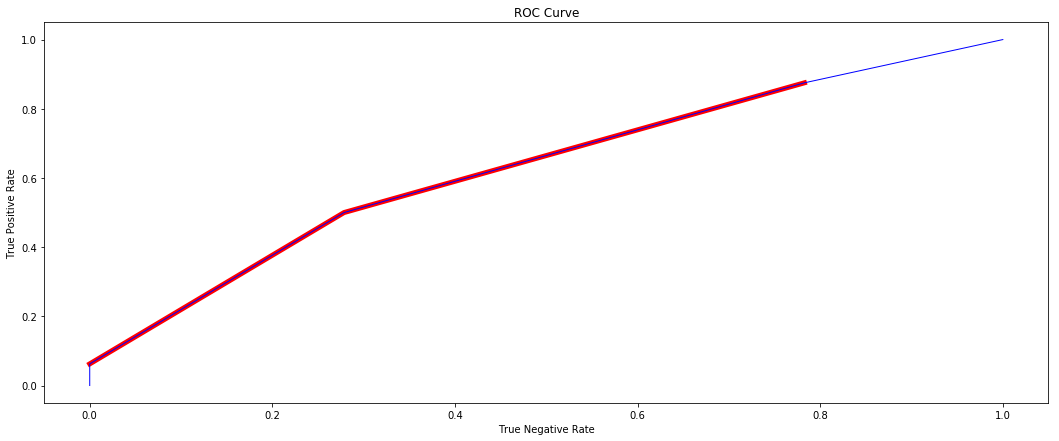

In [9]:
probabilities = classifier.predict_proba(testingFeatures)
ROCRates = []
threshold = 0.01
while threshold < 1:
    ROCRates.append(ROCValues(threshold,probabilities, testingTargets))
    threshold += 0.01
ROCRates = np.array(ROCRates)
#uses the documentation on Scikit Learn for roc_curve to calculate the values
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
fpr, tpr, thresholds = roc_curve(testingTargets, classifier.predict_proba(testingFeatures)[:,1])
plt.rcParams['figure.figsize'] = (18.0, 7.0)
plt.plot(ROCRates[:,0], ROCRates[:,1], color='r', linewidth=5.0)
plt.plot(fpr, tpr, color="b", linewidth=1.0)
plt.ylabel("True Positive Rate")
plt.xlabel("True Negative Rate")
plt.title("ROC Curve")

#uses the documentation on Scikit Learn for auc on how to calculate auc
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
area = auc(fpr, tpr)
print("The area under the ROC curve is: " + str(area))



In [10]:
#follows the Confusion Matrix information page on Scikit Learn to visualize the plots
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plotMatrix(confusionMatrix, title, color):
    classLabels = ["No Outbreak", "Outbreak"]
    plt.rcParams['figure.figsize'] = (5.0, 5.0)
    plt.imshow(confusionMatrix, cmap=plt.cm.Blues)
    plt.xticks(ticks=[0,1], labels=classLabels)
    plt.yticks(ticks=[0,1], labels=classLabels)
    plt.ylabel("Predicted Labels")
    plt.xlabel("True Labels")
    plt.title(title)
    plt.text(0, 0, str(confusionMatrix[0][0]), horizontalalignment="center", verticalalignment="center" ,color="white")
    plt.text(0, 1, str(confusionMatrix[0][1]), horizontalalignment="center", verticalalignment="center" ,color=color)
    plt.text(1, 0, str(confusionMatrix[1][0]), horizontalalignment="center", verticalalignment="center" ,color="black")
    plt.text(1, 1, str(confusionMatrix[1][1]), horizontalalignment="center", verticalalignment="center" ,color="black")
    plt.show()

In [11]:
def findAndPlotConfusionMatrix(predictions, testingTargets):
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    #uses the page to calculate the confusion matrix
    confusionMatrix = confusion_matrix(testingTargets, predictions)
    #uses the Confusion Matrix information page on Scikit Learn to find out how to calculate the normalized matrix
    #https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    normalizedConfusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    plotMatrix(confusionMatrix, "Decision Tree Confusion Matrix (Threshold: 0.5)", "black")
    plotMatrix(normalizedConfusionMatrix, "Decision Tree Normalized Confusion Matrix (Threshold: 0.5)", "white")

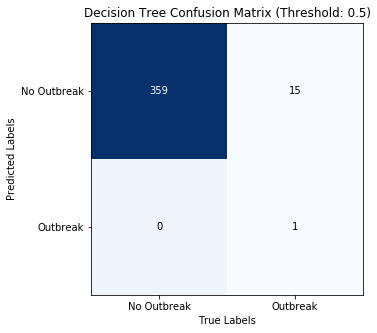

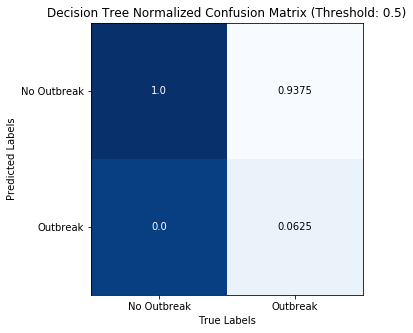

In [12]:
findAndPlotConfusionMatrix(predictions, testingTargets)